# PyDMD

## Tutorial 6: Higher Order Dynamic Mode Decomposition on low dimensional snapshots

In this tutorial we will show the application of the higher order dynamic mode decomposition (for complete description read the original work by [Soledad Le Clainche and José M. Vega](https://epubs.siam.org/doi/10.1137/15M1054924)). This method allows to apply the DMD also when the dimension of the snapshots is less than the number of snapshots: following we will consider a limit case, dealing with 1D snapshots.

First of all we import the HODMD class from the pydmd package, we set matplotlib for the notebook and we import numpy.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from pydmd import HODMD
from pydmd.plotter import plot_eigs

Now, we create our toy dataset: we evaluate a nonlinear function in equispaced points, in order to simulate a temporal signal. Here our function:

$
f(t) = \cos(t)\sin(\cos(t)) + \cos(\frac{t}{5})
$

In [2]:
def myfunc(x):
    return np.cos(x)*np.sin(np.cos(x)) + np.cos(x*.2)

Because we trust in the DMD power, we add a bit of noise and we plot our function:

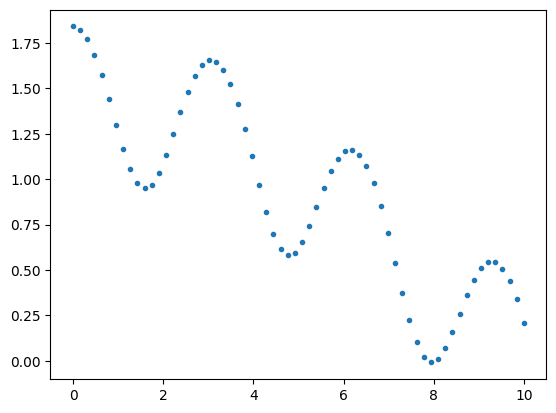

In [3]:
x = np.linspace(0, 10, 64)
y = myfunc(x)
snapshots = y
plt.plot(x, snapshots, '.')
plt.show()

Now we create the `HODMD` object: in addition to the usual DMD parameters, we have the `d` parameter. Basically, using this method the initial snapshots matrix is rearranged in order to be able to extract the main structures using the singular value decomposition. This parameter `d` handle this arrangement (for further details, check the [HODMD](https://mathlab.github.io/PyDMD/hodmd.html) documentation).

In [4]:
hodmd = HODMD(svd_rank=0, exact=True, opt=True, d=30).fit(snapshots[None])

/Users/francescoandreuzzi/code/units/PyDMD/pydmd/hodmd.py:131: UserWarning: The parameter 'svd_rank_extra=0' has been ignored because the given system is a scalar function
  warnings.warn((


Despite the arrangement, the shape of the reconstructed data is the same of the original input.

In [5]:
hodmd.reconstructed_data.shape

(1, 64)

As always, we take a look at the eigenvalues to check the stability of the system.

/Users/francescoandreuzzi/code/units/PyDMD/pydmd/plotter.py:185: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(


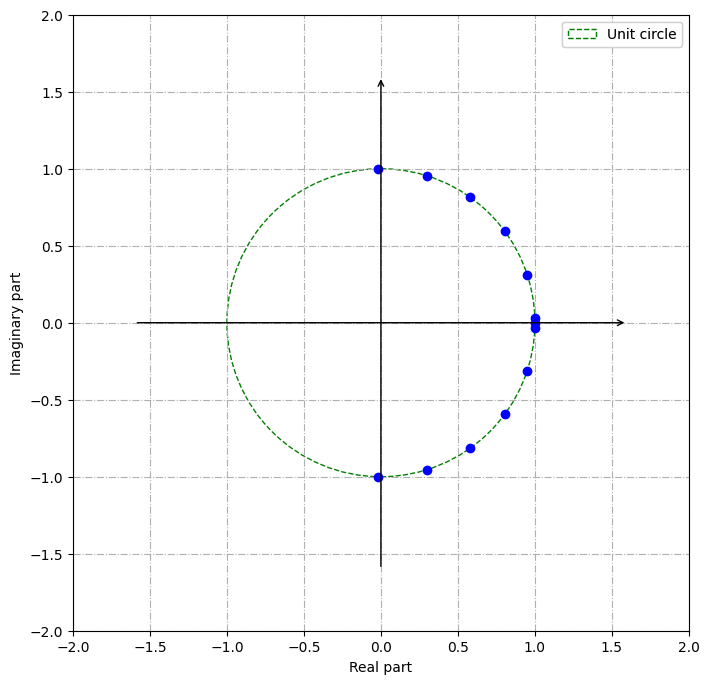

In [6]:
plot_eigs(hodmd)

Now we can compare the DMD output with the inital dataset: we plot the snapshots, the original function we are trying to reconstruct and the DMD reconstruction.

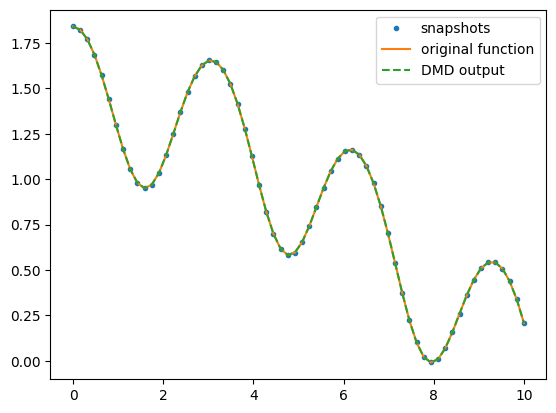

In [7]:
hodmd.original_time['dt'] = hodmd.dmd_time['dt'] = x[1] - x[0]
hodmd.original_time['t0'] = hodmd.dmd_time['t0'] = x[0]
hodmd.original_time['tend'] = hodmd.dmd_time['tend'] = x[-1]

plt.plot(hodmd.original_timesteps, snapshots, '.', label='snapshots')
plt.plot(hodmd.original_timesteps, y, '-', label='original function')
plt.plot(hodmd.dmd_timesteps, hodmd.reconstructed_data[0].real, '--', label='DMD output')
plt.legend()
plt.show()

Quite good! Let see if we can see in the future.

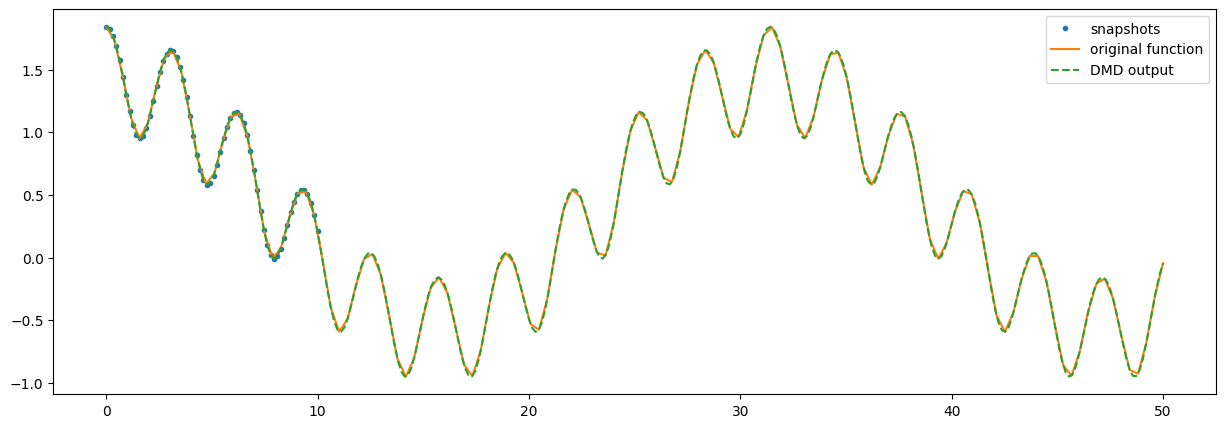

In [8]:
hodmd.dmd_time['tend'] = 50

fig = plt.figure(figsize=(15, 5))
plt.plot(hodmd.original_timesteps, snapshots, '.', label='snapshots')
plt.plot(np.linspace(0, 50, 128), myfunc(np.linspace(0, 50, 128)), '-', label='original function')
plt.plot(hodmd.dmd_timesteps, hodmd.reconstructed_data[0].real, '--', label='DMD output')
plt.legend()
plt.show()

The reconstruction is perfect. Also when time is far away from the snapshots.

We can check what happens  if we add some noise.

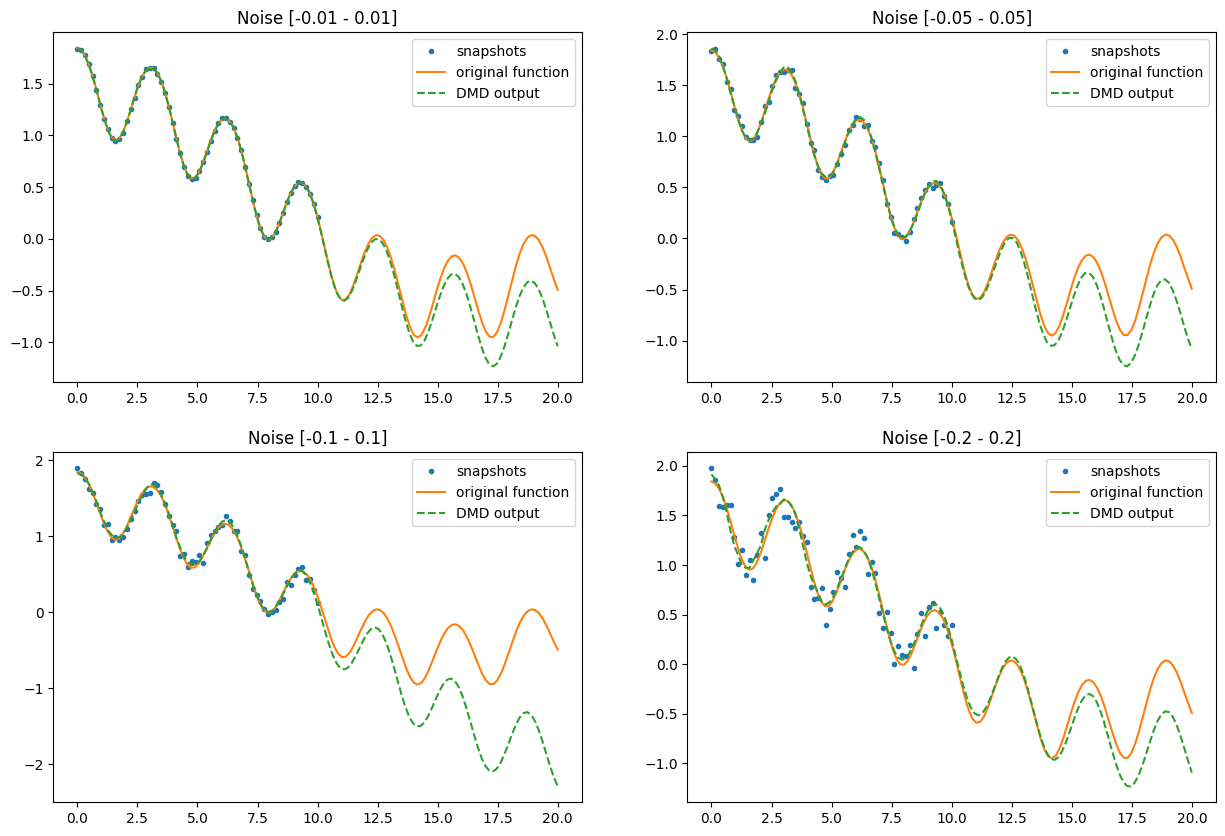

In [10]:
noise_range = [.01, .05, .1, .2]
fig = plt.figure(figsize=(15, 10))
future = 20

for id_plot, i in enumerate(noise_range, start=1):
    snapshots = y + np.random.uniform(-i, i, size=y.shape)
    hodmd = HODMD(svd_rank=0, exact=True, opt=True, d=30).fit(snapshots[None])
    hodmd.original_time['dt'] = hodmd.dmd_time['dt'] = x[1] - x[0]
    hodmd.original_time['t0'] = hodmd.dmd_time['t0'] = x[0]
    hodmd.original_time['tend'] = hodmd.dmd_time['tend'] = x[-1]
    hodmd.dmd_time['tend'] = 20
    
    plt.subplot(2, 2, id_plot)
    plt.plot(hodmd.original_timesteps, snapshots, '.', label='snapshots')
    plt.plot(np.linspace(0, future, 128), myfunc(np.linspace(0, future, 128)), '-', label='original function')
    plt.plot(hodmd.dmd_timesteps, hodmd.reconstructed_data[0].real, '--', label='DMD output')
    plt.legend()
    plt.title('Noise [{} - {}]'.format(-i, i))
plt.show()

Results are obviously worst, but depending from the amount of noise the HODMD output matches the original function pretty well, at least in a short-time prevision. Within the temporal window, instead, it can reconstruct very well the trend and denoise the input data.